# Start Dask

In [1]:
import dask.dataframe as dd
from dask.distributed import Client

#Initializing client
client = Client()
client

/anaconda3/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://127.0.0.1:56932 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


# Objective

The objective of this notebook is to answer two main questions: 
 - "The JSON values are always from the same location or related domains?" 
 - "Are there a set of location domains that always produces a JSON?"

To answer this we will use the sample data set produced by the notebook "isJson_dataPrep.ipynb" called 'all_json_above_mean.parquet' for first question and 'is_json_above_mean_md5.parquet' for seccond, this contains two extra calculated columns that will be important: 'is_json' and 'location_domain'.


<sub>OBS.: For "value" comparison I will use instead value_md5, because its reliable and faster. Value_md5 is the calculated md5 for the value columns  
OBS2.: To see validation that all biggest values are json please reffer to 'isJson_Sample_Comparasion.ipynb'</sub>

### Findings: 

On this notebook I was able to validate couple facts about the two proposed questions, which are: 
- One domain produces multiple JSONs
- One JSON is usually (99.9%) produced by a single domain. 


- One domain can produce values there are both Json or not, but most produce only one type
- Most of the domains that produce a single type produces JSON type. 

---

# Are there a set of location domains that always produces a JSON?
The dataset used to this analise contains non-json values as well for the sake of proving that one domain may or may not produce only json values.

In [37]:
df = dd.read_parquet('is_json_above_mean_md5.parquet', engine='pyarrow', columns=['value_md5', 'is_json', 'location_domain'])
df.columns

Index(['value_md5', 'is_json', 'location_domain'], dtype='object')

In [38]:
df.head()

,value_md5,is_json,location_domain
0,cff77029e3ae45dd439a62987b1d8340,True,canada.ca
1,9ac0a0a0afb677c8fd985a7c2f4ddbc5,True,tmall.com
2,9ac0a0a0afb677c8fd985a7c2f4ddbc5,True,tmall.com
3,db64465b639e01993d9212390f057628,False,coches.net
4,db64465b639e01993d9212390f057628,False,coches.net


In [60]:
location_domain_group = df.compute().groupby('location_domain')

In [160]:
agg = location_domain_group.agg({'value_md5': ['nunique', 'count'], 'is_json': ['sum', 'nunique']})

In [161]:
agg.head()

value_md5       is_json        
                    nunique count     sum nunique
location_domain                                  
0123movies.com            2     2     2.0       1
10010.com                 2     8     8.0       1
1001freefonts.com        20   155   155.0       1
10fastfingers.com         4    28    28.0       1
10jqka.com.cn             7    30    30.0       1

In [178]:
#Count the number of domains that only produce one type of value (json or non-json)
f1 = agg['is_json']['nunique'] == 1
agg_1 = agg[f1]
oneType = len(agg_1['is_json'])
oneType

1563

In [180]:
#Out of the ones there have only one type of output, these are the ones that have as JSON
f2 = agg['is_json']['sum'] > 0
agg_1a = agg[f1 & f2]
oneType_json = len(agg_1a['is_json'])
oneType_json

1226

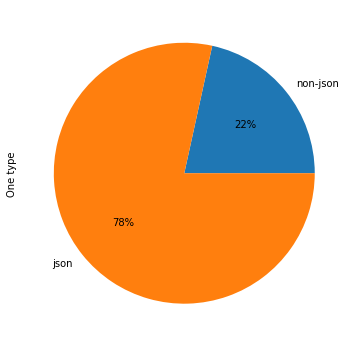

In [185]:
series = pd.Series([(oneType - oneType_json), (oneType_json)], index=['non-json', 'json'], name='One type')
series.plot.pie(figsize=(6, 6), autopct='%1.0f%%')

In [179]:
#Count the number of domains that only produce one BOTH json and non-json values
agg_2 = agg[agg['is_json']['nunique'] == 2]
twoTypes = len(agg_2['is_json'])
twoTypes

294

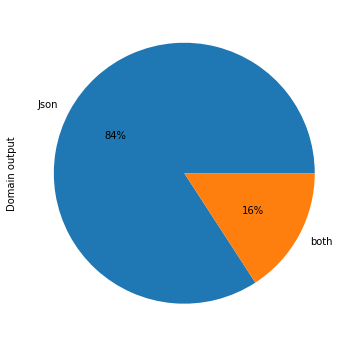

In [187]:
series = pd.Series([(oneType), (twoTypes)], index=['Json', 'both'], name='Domain output')
series.plot.pie(figsize=(6, 6), autopct='%1.0f%%')

## Conclusion
Most of the domains has only one type of value output, but not all of them. 16% have outputs that can be json and non-json

Out of the ones that has one value type, 78% is json. 

>Are there a set of location domains that always produces a JSON?

Yes, there is a set that always produces the value as a valid JSON, but not all of them. There are also the ones there never produces JSON and some that produces both. 

---

In [189]:
#Using the above methoed I could tell that the domains did not have only one 
#output, but I could not find a way to tell the output type. 
#Thats why I decided to calculate by hand as you propably notice, sorry. 

location_domain_group_unique_md5 = location_domain_group['value_md5'].nunique()
location_domain_group_unique_md5.sort_values(ascending=False).head()

location_domain
twitter.com      5594
petsmart.com     2313
cdiscount.com    1835
debenhams.com    1229
mediamarkt.de    1094
Name: value_md5, dtype: int64

---

## The JSON values are always from the same location or related domains?
For "value" comparison I will use value_md5 instead, because its reliable and faster

* value_md5 is the calculated md5 for the value columns

In [191]:
df = dd.read_parquet('all_json_above_mean.parquet', columns=['value_md5','location_domain', 'value_len'])
df.columns

Index(['value_md5', 'location_domain', 'value_len'], dtype='object')

In [192]:
df.head()

,value_md5,location_domain,value_len
0,cff77029e3ae45dd439a62987b1d8340,canada.ca,3713
1,9ac0a0a0afb677c8fd985a7c2f4ddbc5,tmall.com,103878
2,9ac0a0a0afb677c8fd985a7c2f4ddbc5,tmall.com,103878
3,983f2d6827a86b128a02cf7442c94af1,coches.net,1686
4,b2ad4d7452aeed3df181b1501cc20231,coches.net,1686


In [196]:
md5Group = df.compute().groupby('value_md5')

/anaconda3/envs/overscripted/lib/python3.6/site-packages/distributed/worker.py:2791: UserWarning: Large object of size 1.89 MB detected in task graph: 
  (<dask.bytes.local.LocalFileSystem object at 0x122 ... : 'value_md5'})
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [201]:
uniquePerGroup = md5Group['location_domain'].nunique().sort_values(ascending=False)

In [202]:
uniquePerGroup.head()

value_md5
9ac0a0a0afb677c8fd985a7c2f4ddbc5    9
5ec2e3a352164b86a9826d5f83bbebac    8
0e39ea3d9346b2c98c605a5697b314c6    6
be58f7715071d1cc741f04a9d6e16892    6
618004cfffbb7b5ef1e25489fc2d7c94    6
Name: location_domain, dtype: int64

One Value is NOT produced always by the same domain, but each value does have very few domains. 

In [204]:
aggmd = md5Group.agg({'location_domain': ['nunique']})

In [207]:
aggmd.head()

,location_domain
,nunique
value_md5,
000599fa6f59053c67e6ccbef137a0d2,1
0005e12de9897336bf5c7e352a807568,1
00076462ead16ac77a1d56745584fd5b,1
0007a2345e42bca1d5cac86e356bb87b,1
000b0b6b104a36cbc6f31b923e1b31a7,1


In [210]:
f1 = aggmd['location_domain']['nunique'] > 1
aggf = aggmd[f1]

In [215]:
unique_values_count = len(aggmd)
unique_values_count

35746

In [218]:
values_multiple_origin = len(aggf)
values_single_origin = unique_values_count - values_multiple_origin 
(values_multiple_origin, values_single_origin )

(35, 35711)

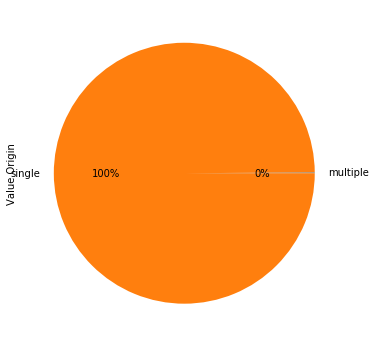

In [219]:
series = pd.Series([(values_multiple_origin), (values_single_origin)], index=['multiple', 'single'], name='Value Origin')
series.plot.pie(figsize=(6, 6), autopct='%1.0f%%')

## Conclusion
The absolute most values have only one origin. Only 35 occurencies of the same value are found to have more than one domain origin. 

>The JSON values are always from the same location or related domains?

Almost, 0,097% of the values have multiple origins, but 99,9% is only produced by one domain. 

---